In [1]:
import os
import torch
import sys
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.manifold import TSNE
import pylab as py
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier


import warnings
warnings.filterwarnings('ignore')

from fastprogress import master_bar, progress_bar

In [2]:
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [3]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

In [4]:
num_epochs = 100
batch_size = 512
learning_rate = 1e-3

In [5]:
train_dataset = MNIST('../data', train=True, transform=img_transform)
test_dataset = MNIST('../data', train=False, transform=img_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [6]:
device = 'cuda:4' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:4


In [7]:
class DAM(nn.Module):
    """ Discriminative Amplitude Modulator Layer (1-D) """
    def __init__(self, in_dim):
        super(DAM, self).__init__()
        self.in_dim = in_dim
        
        self.mu = torch.arange(0, self.in_dim).float()/self.in_dim * 5
        self.mu = nn.Parameter(self.mu, requires_grad=False)
        self.beta = nn.Parameter(torch.ones(1), requires_grad=True)
        self.alpha = nn.Parameter(torch.ones(1), requires_grad=False)
        self.register_parameter('mu', self.mu)
        self.register_parameter('beta', self.beta)
        self.register_parameter('alpha', self.alpha)
        
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return x * self.mask()
    
    def mask(self):
        return self.relu(self.tanh((self.alpha ** 2) * (self.mu + self.beta)))

In [8]:
class AEnc(nn.Module):
    def __init__(self, init_dim):
        super(AEnc, self).__init__()
        self.enc_layer_1 = nn.Linear(28 * 28, 128)
        self.enc_layer_2 = nn.Linear(128, 64)
        self.enc_layer_3 = nn.Linear(64, 32)
        self.enc_layer_4 = nn.Linear(32, init_dim)
        self.dam_layer = DAM(init_dim)
        self.dec_layer_1 = nn.Linear(init_dim, 32)
        self.dec_layer_2 = nn.Linear(32, 64)
        self.dec_layer_3 = nn.Linear(64, 128)
        self.dec_layer_4 = nn.Linear(128, 28 * 28)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        
    def forward(self, x):
        out = self.relu(self.enc_layer_1(x))
        out = self.relu(self.enc_layer_2(out))
        out = self.relu(self.enc_layer_3(out))
        h = self.enc_layer_4(out)
        h = self.dam_layer(h)
        x_r = self.relu(self.dec_layer_1(h))
        x_r = self.relu(self.dec_layer_2(x_r))
        x_r = self.relu(self.dec_layer_3(x_r))
        x_r = self.tanh(self.dec_layer_4(x_r))
        return x_r, h

In [9]:
class SLM(nn.Module):
    """ Network Sliming Modulator Layer (1-D) """
    def __init__(self, in_dim):
        super(SLM, self).__init__()
        self.in_dim = in_dim
        self.mu = nn.Parameter(torch.ones(self.in_dim).float(), requires_grad=True)
        self.register_parameter('mu', self.mu)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return x * self.mask()
    
    def mask(self):
        return self.relu(self.mu)

In [10]:
class AEncS(nn.Module):
    def __init__(self, init_dim):
        super(AEncS, self).__init__()
        self.enc_layer_1 = nn.Linear(28 * 28, 128)
        self.enc_layer_2 = nn.Linear(128, 64)
        self.enc_layer_3 = nn.Linear(64, 32)
        self.enc_layer_4 = nn.Linear(32, init_dim)
        self.dam_layer = SLM(init_dim)
        self.dec_layer_1 = nn.Linear(init_dim, 32)
        self.dec_layer_2 = nn.Linear(32, 64)
        self.dec_layer_3 = nn.Linear(64, 128)
        self.dec_layer_4 = nn.Linear(128, 28 * 28)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        
    def forward(self, x):
        out = self.relu(self.enc_layer_1(x))
        out = self.relu(self.enc_layer_2(out))
        out = self.relu(self.enc_layer_3(out))
        h = self.enc_layer_4(out)
        h = self.dam_layer(h)
        x_r = self.relu(self.dec_layer_1(h))
        x_r = self.relu(self.dec_layer_2(x_r))
        x_r = self.relu(self.dec_layer_3(x_r))
        x_r = self.tanh(self.dec_layer_4(x_r))
        return x_r, h

In [15]:
def test_predict(train_embd, train_label, test_embd, test_label, solver='lbfgs',
             multi_class='auto', *args, **kwargs):
        r"""Evaluates latent space quality via a logistic regression downstream
        task."""
        clf = MLPClassifier(hidden_layer_sizes=(50, 50), random_state=1, max_iter=100).fit(train_embd, train_label)
        return f1_score(test_label, clf.predict(test_embd), average='macro')

In [21]:
def downstream(net):
    train_z = []
    train_y = []
    for data in train_loader:
        img, label = data
        img = img.view(img.size(0), -1)
        img = img.to(device)
        output, embd = net(img)
        train_z += embd.detach().cpu().numpy().tolist()
        train_y += label.detach().cpu().numpy().tolist()
        
    train_embd = np.array(train_z)
    train_label = np.array(train_y)
    
    test_z = []
    test_y = []
    for data in test_loader:
        img, label = data
        img = img.view(img.size(0), -1)
        img = img.to(device)
        output, embd = net(img)
        test_z += embd.detach().cpu().numpy().tolist()
        test_y += label.detach().cpu().numpy().tolist()

    test_embd = np.array(test_z)
    test_label = np.array(test_y)
    
    return test_predict(train_embd, train_label, test_embd, test_label, max_iter=150)

In [23]:
init_dims = [50] #100
lambda_rs = [0.01, 0.05, 0.1, 0.5, 1, 2, 5]
dam_btl_dim_mean = []
dam_btl_dim_std = []
dam_rec_loss_mean = []
dam_rec_loss_std = []

dam_btl_dims = []
dam_rec_losses = []

criterion = nn.MSELoss()

for init_dim in init_dims:
    init_dim_btl_mean = []
    init_dim_btl_std = []
    init_dim_rec_mean = []
    init_dim_rec_std = []
    for lambda_r in lambda_rs:
        btl_neurons = []
        rec_loss = []
        model_name = str(init_dim)+'x'+str(lambda_r)
        for run in range(1, 6):
            net = AEnc(init_dim).to(device)
            net.load_state_dict(torch.load('saved_models/dam_model_'+model_name+'_run_'+str(run)+'.pt'))
            
            btl_d = (net.dam_layer.mask().detach().cpu().numpy() > 0).sum()
            btl_neurons.append(btl_d)
            
            net.eval()
            rec_loss.append(downstream(net))
        
        dam_btl_dims += btl_neurons
        dam_rec_losses += rec_loss 
        init_dim_btl_mean.append(np.mean(btl_neurons))
        init_dim_btl_std.append(np.std(btl_neurons))
        init_dim_rec_mean.append(np.mean(rec_loss))
        init_dim_rec_std.append(np.std(rec_loss))
        
    dam_btl_dim_mean.append(init_dim_btl_mean)
    dam_btl_dim_std.append(init_dim_btl_std)
    dam_rec_loss_mean.append(init_dim_rec_mean)
    dam_rec_loss_std.append(init_dim_rec_std)
            

In [24]:
slm_btl_dim_mean = []
slm_btl_dim_std = []
slm_rec_loss_mean = []
slm_rec_loss_std = []

slm_btl_dims = []
slm_rec_losses = []

criterion = nn.MSELoss()

for init_dim in init_dims:
    init_dim_btl_mean = []
    init_dim_btl_std = []
    init_dim_rec_mean = []
    init_dim_rec_std = []
    for lambda_r in lambda_rs:
        btl_neurons = []
        rec_loss = []
        model_name = str(init_dim)+'x'+str(lambda_r)
        for run in range(1, 6):
            net = AEncS(init_dim).to(device)
            net.load_state_dict(torch.load('saved_models/slm_model_'+model_name+'_run_'+str(run)+'.pt'))
            
            btl_d = (net.dam_layer.mask().detach().cpu().numpy() > 0).sum()
            btl_neurons.append(btl_d)
            
            net.eval()
            rec_loss.append(downstream(net))
            
        slm_btl_dims += btl_neurons
        slm_rec_losses += rec_loss 
        init_dim_btl_mean.append(np.mean(btl_neurons))
        init_dim_btl_std.append(np.std(btl_neurons))
        init_dim_rec_mean.append(np.mean(rec_loss))
        init_dim_rec_std.append(np.std(rec_loss))
        
    slm_btl_dim_mean.append(init_dim_btl_mean)
    slm_btl_dim_std.append(init_dim_btl_std)
    slm_rec_loss_mean.append(init_dim_rec_mean)
    slm_rec_loss_std.append(init_dim_rec_std)

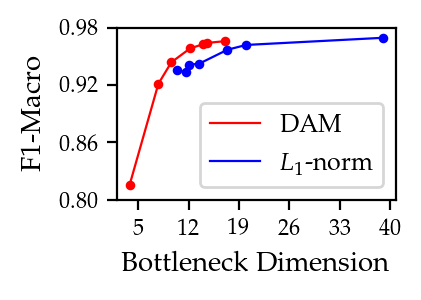

In [90]:
fig, ax = plt.subplots(figsize=(2.2, 1.60), dpi=200)

plt.scatter( dam_btl_dim_mean[0], dam_rec_loss_mean[0],marker='o', s=6, color='r')
plt.plot( dam_btl_dim_mean[0], dam_rec_loss_mean[0], color='r', label='DAM', lw=0.8)
plt.scatter(slm_btl_dim_mean[0], slm_rec_loss_mean[0], marker='o', s=6, color='b')
plt.plot(slm_btl_dim_mean[0], slm_rec_loss_mean[0], color='b', label='$L_{1}$-norm', lw=.8)


py.legend(loc='lower right', fontsize=9)
plt.xlabel('Bottleneck Dimension')
plt.ylabel('F1-Macro')
plt.xticks(np.arange(5, max(del_slm_btl_dim_mean)+2, 7), fontsize=8)
plt.yticks(np.linspace(start=0.80, stop=0.98, num=4), fontsize=8)


fig.tight_layout()
fig.savefig("plots/mnist_f1_macro.pdf", dpi=400, transparent=True, bbox_inches='tight')
plt.show()

In [91]:
d = {
    'dam_btl_dim_mean': dam_btl_dim_mean,
    'dam_rec_loss_mean': dam_rec_loss_mean,
    'slm_btl_dim_mean': slm_btl_dim_mean,
    'slm_rec_loss_mean': slm_rec_loss_mean
}
np.save('saved_models/mnist_mlp_clf.npy', d, allow_pickle=True)